1. 建議python版本:3.11
2. 參考來源: https://www.kaggle.com/code/fareselmenshawii/cats-vs-dogs-classification/notebook


In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import (
    Conv2D,
    Add,
    MaxPooling2D,
    Dense,
    BatchNormalization,
    Input,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator


([<matplotlib.patches.Wedge at 0x2d95562f750>,
 [Text(-1.1, 1.3471114790620887e-16, 'Dog'),
  Text(1.1, -2.6942229581241775e-16, 'Cat')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.6, -1.4695761589768238e-16, '50.0%')])

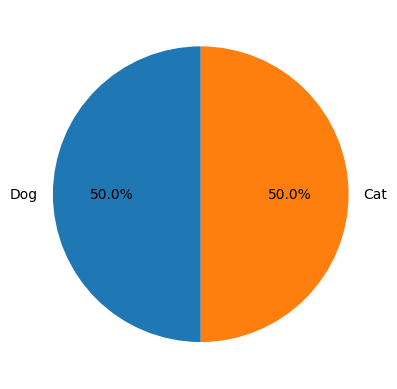

In [14]:
class_names = ["Dog", "Cat"]

n_dogs = len(os.listdir("PetImages/Dog"))
n_cats = len(os.listdir("PetImages/Cat"))
n_images = [n_cats, n_dogs]
plt.pie([n_dogs, n_cats], startangle=90, labels=class_names, autopct="%.1f%%")

<a name="2-1"></a>
## create directories for training and validation

In [ ]:
# 建立資料夾,只需執行一次
try:
    os.mkdir("cats-v-dogs")
    os.mkdir("cats-v-dogs/training")
    os.mkdir("cats-v-dogs/validation")
    os.mkdir("cats-v-dogs/test")
    os.mkdir("cats-v-dogs/training/cats")
    os.mkdir("cats-v-dogs/training/dogs")
    os.mkdir("cats-v-dogs/validation/cats")
    os.mkdir("cats-v-dogs/validation/dogs")
    os.mkdir("cats-v-dogs/test/cats")
    os.mkdir("cats-v-dogs/test/dogs")
except OSError:
    print("Error failed to make directory")

In [4]:
# Define data path
CAT_DIR = "PetImages/Cat"
DOG_DIR = "PetImages/Dog"

TRAINING_DIR = "cats-v-dogs/training/"
VALIDATION_DIR = "cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [5]:
print(len(os.listdir("cats-v-dogs/training/cats")))
print(len(os.listdir("cats-v-dogs/training/dogs")))

print(len(os.listdir("cats-v-dogs/validation/cats")))
print(len(os.listdir("cats-v-dogs/validation/dogs")))

print(len(os.listdir("cats-v-dogs/test/cats")))
print(len(os.listdir("cats-v-dogs/test/dogs")))

11250
11250
625
625
625
625


**Now let's create  a function to split the   data**

In [6]:
def split_data(
    main_dir,
    training_dir,
    validation_dir,
    test_dir=None,
    include_test_split=True,
    split_size=0.9,
):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(
            os.path.join(main_dir, file)
        ):  # check if the file's size isn't 0
            files.append(file)  # appends file name to a list

    shuffled_files = random.sample(files, len(files))  # shuffles the data
    split = int(
        0.9 * len(shuffled_files)
    )  # the training split casted into int for numeric rounding
    train = shuffled_files[:split]  # training split
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test]  # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(
            os.path.join(main_dir, element), os.path.join(training_dir, element)
        )  # copy files into training directory

    for element in validation:
        copyfile(
            os.path.join(main_dir, element), os.path.join(validation_dir, element)
        )  # copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(
                os.path.join(main_dir, element), os.path.join(test_dir, element)
            )  # copy files into test directory
    print("Split sucessful!")

**Now let's call the function to create the  training/validation data**

In [7]:
split_data(
    CAT_DIR,
    "cats-v-dogs/training/cats",
    "cats-v-dogs/validation/cats",
    "cats-v-dogs/test/cats",
    INCLUDE_TEST,
    0.9,
)
split_data(
    DOG_DIR,
    "cats-v-dogs/training/dogs",
    "cats-v-dogs/validation/dogs",
    "cats-v-dogs/test/dogs",
    INCLUDE_TEST,
    0.9,
)

Split sucessful!
Split sucessful!


**As a sanity check let's check the data directories**

In [9]:
print(len(os.listdir("cats-v-dogs/training/cats")))
print(len(os.listdir("cats-v-dogs/training/dogs")))

print(len(os.listdir("cats-v-dogs/validation/cats")))
print(len(os.listdir("cats-v-dogs/validation/dogs")))


print(len(os.listdir("cats-v-dogs/test/cats")))
print(len(os.listdir("cats-v-dogs/test/dogs")))

12364
12394
1211
1227
1213
1215


<a name="2-2"></a>

## Create Generators

In [10]:
train_gen = ImageDataGenerator(rescale=1.0 / 255)

validation_gen = ImageDataGenerator(rescale=1.0 / 255.0)

if INCLUDE_TEST:
    test_gen = ImageDataGenerator(rescale=1.0 / 255.0)


In [11]:
train_generator = train_gen.flow_from_directory(
    "cats-v-dogs/training", target_size=(150, 150), batch_size=64, class_mode="binary"
)
validation_generator = validation_gen.flow_from_directory(
    "cats-v-dogs/validation", target_size=(150, 150), batch_size=64, class_mode="binary"
)

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        "cats-v-dogs/validation",
        target_size=(150, 150),
        batch_size=64,
        class_mode="binary",
    )

Found 24756 images belonging to 2 classes.
Found 2438 images belonging to 2 classes.
Found 2438 images belonging to 2 classes.


**Now let's make sure we got the correct data**

In [ ]:
# test_generator
for x, y in enumerate(test_generator):
    print(y)


In [18]:
class_names = ["Cat", "Dog"]


def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = next(generator)
    # images, labels = generator.next()
    labels = labels.astype("int32")

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")
        i += 1
        if i == n_images:
            break

    plt.show()

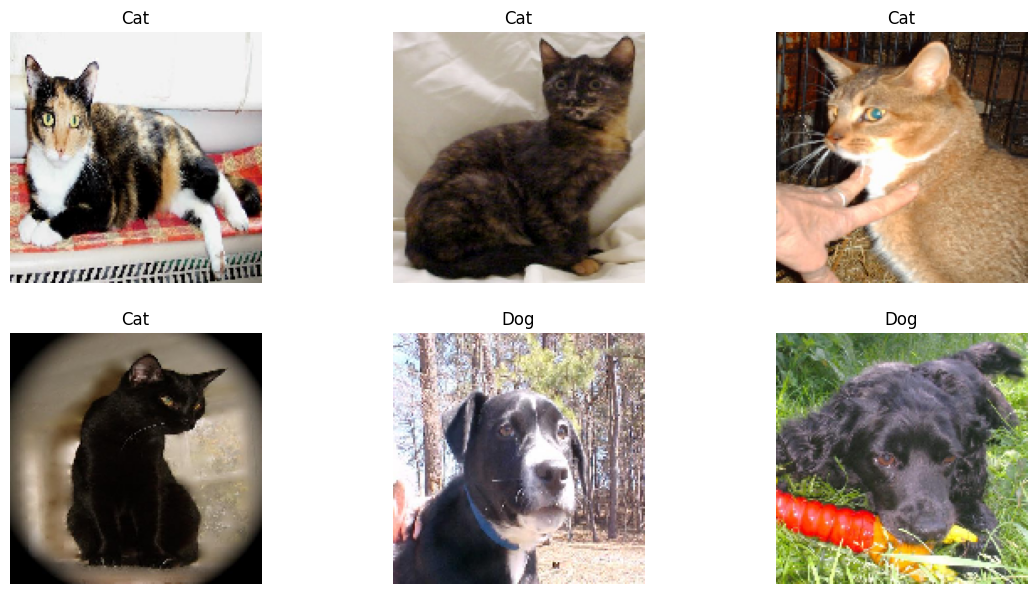

In [19]:
plot_data(train_generator, 7)


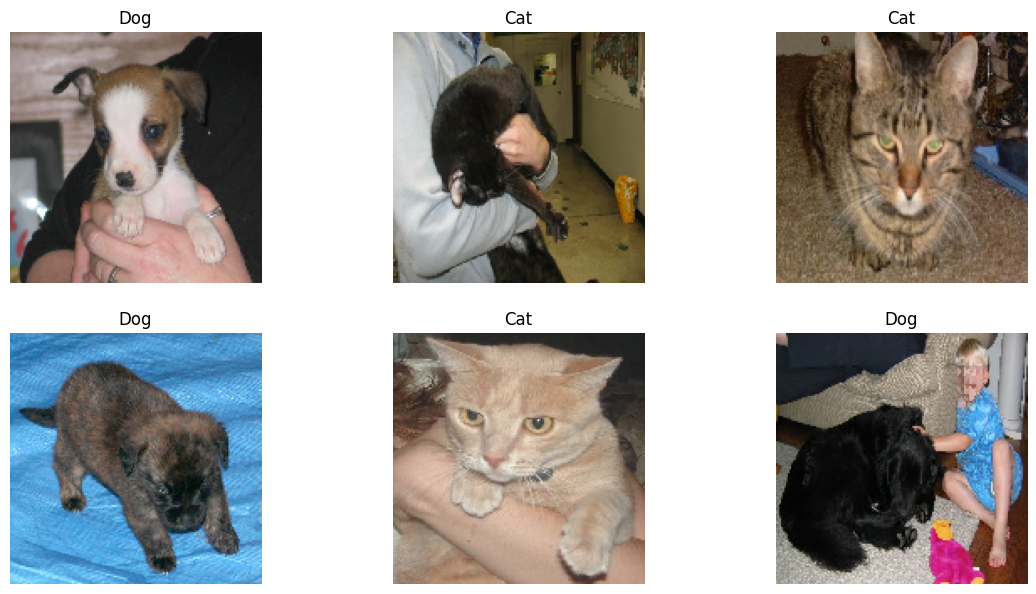

In [20]:
plot_data(validation_generator, 7)


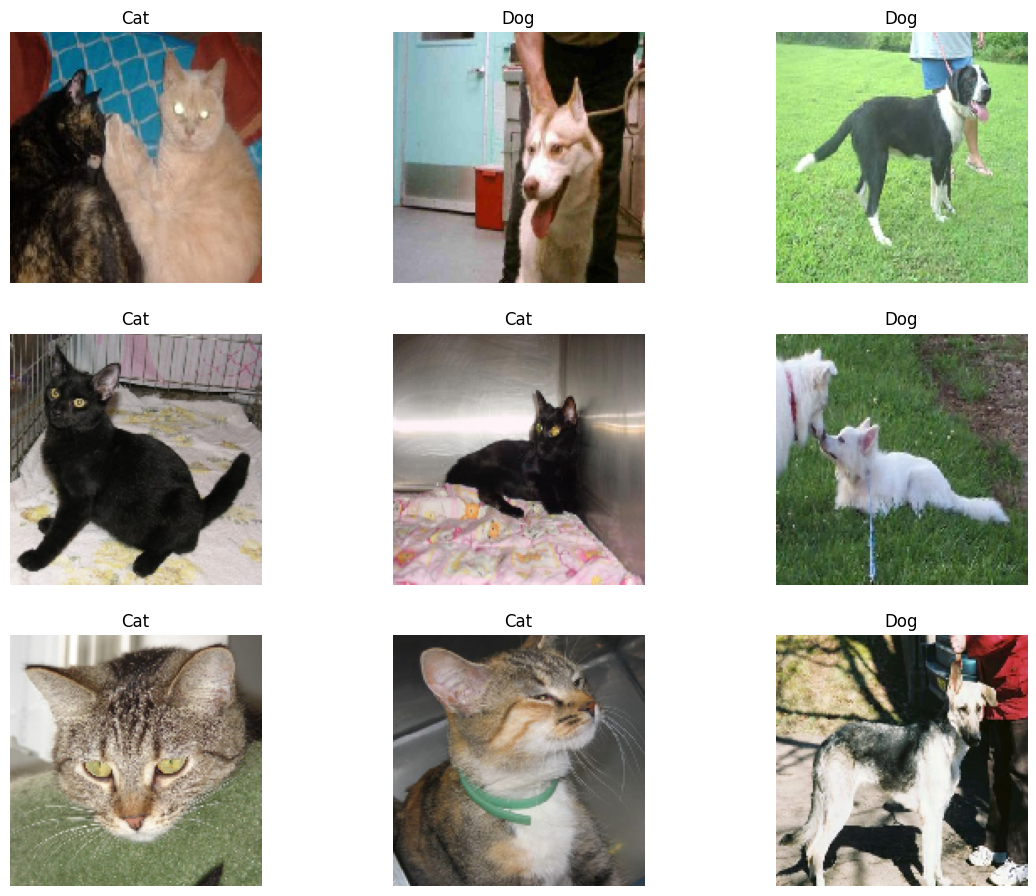

In [21]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [22]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=x)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [24]:
# 訓練時間很久哦
r = model.fit(
    train_generator,
    epochs=10,  # 可多次訓練,提昇正確率
    validation_data=validation_generator,
)

Epoch 1/10


c:\Users\ELSA\anaconda3\envs\Py11\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/387 ━━━━━━━━━━━━━━━━━━━━ 3:40 939ms/step - accuracy: 0.5125 - loss: 0.6940

c:\Users\ELSA\anaconda3\envs\Py11\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


387/387 ━━━━━━━━━━━━━━━━━━━━ 386s 990ms/step - accuracy: 0.5291 - loss: 0.6898 - val_accuracy: 0.6308 - val_loss: 0.6371
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.6355 - loss: 0.6399 - val_accuracy: 0.6874 - val_loss: 0.6002
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 383s 987ms/step - accuracy: 0.6762 - loss: 0.5990 - val_accuracy: 0.7088 - val_loss: 0.5622
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.7030 - loss: 0.5708 - val_accuracy: 0.7084 - val_loss: 0.5562
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 388s 1000ms/step - accuracy: 0.7247 - loss: 0.5493 - val_accuracy: 0.5976 - val_loss: 0.6850
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 384s 991ms/step - accuracy: 0.7277 - loss: 0.5439 - val_accuracy: 0.7395 - val_loss: 0.5345
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 383s 989ms/step - accuracy: 0.7431 - loss: 0.5223 - val_accuracy: 0.7621 - val_loss: 0.4907
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 383s 988ms/step - accuracy: 0.7584 - loss: 0.5050 - 

In [25]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.8104 - loss: 0.4295


<a name="4-2"></a>

## Visualize the predicitons

In [26]:
def plot_prediction(generator, n_images):
    i = 1
    images, labels = next(generator)
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype("int32")
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color="g")
            plt.axis("off")
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color="r")
            plt.axis("off")
        i += 1
        if i == n_images:
            break

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


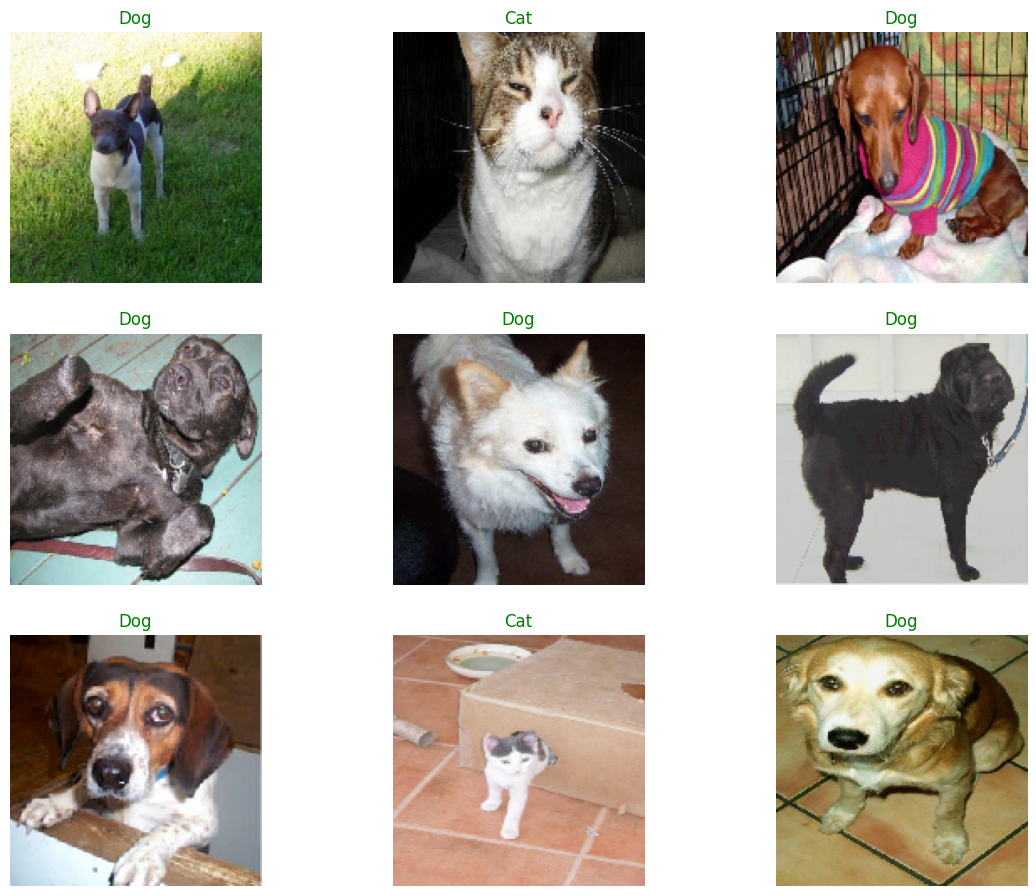

In [27]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


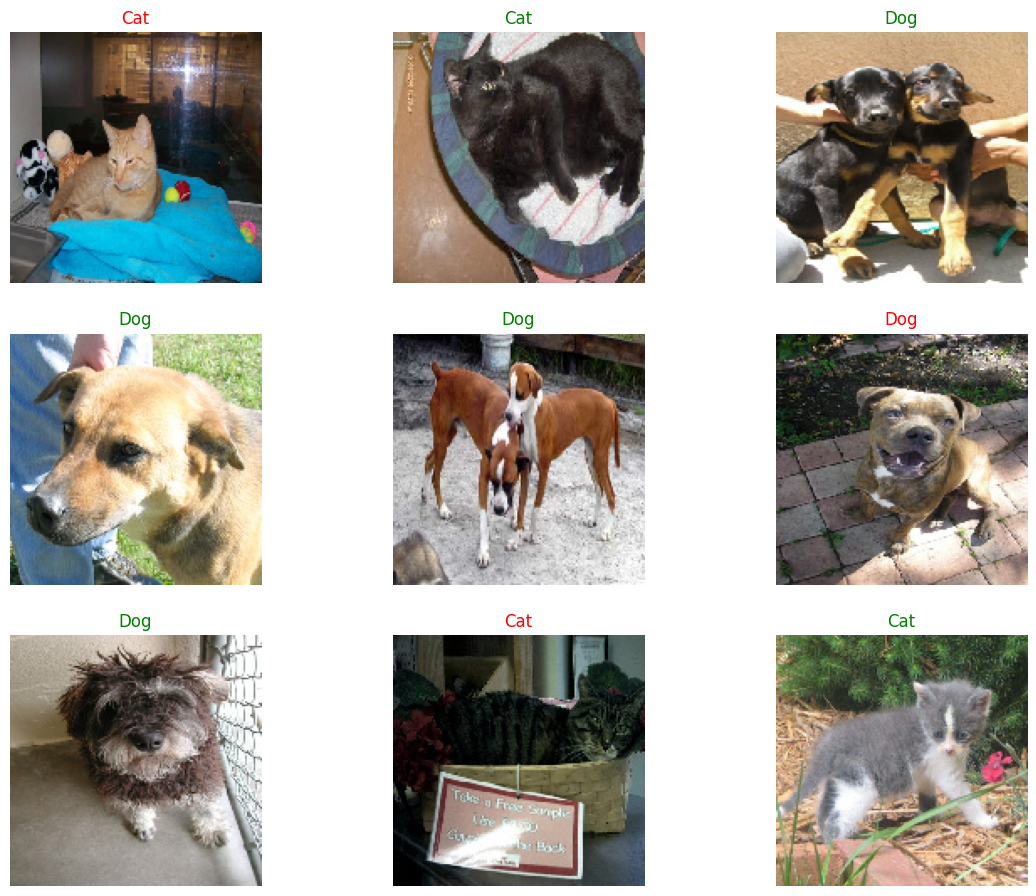

In [28]:
plot_prediction(validation_generator, 10)

<a name="4-3"></a>

## Visualize class activation maps

In [29]:
# Create a  model to visualize activation maps
gp_weights = model.get_layer("dense").get_weights()[0]
activation_model = Model(
    model.inputs,
    outputs=(model.get_layer("conv2d_5").output, model.get_layer("dense_1").output),
)

In [30]:
# Use the model to make predictions on the test generator
images, _ = next(test_generator)
features, results = activation_model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


In [31]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index, :, :, :]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:, prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(
        features_for_img, (150 / 30, 150 / 30, 1), order=2
    )

    # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)

    print(
        "Predicted Class = "
        + str(class_names[prediction])
        + ", Probability = "
        + str(results[image_index][prediction])
    )

    # show the upsampled image

    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction] > 0.95:
        cmap_str = "Greens"
    else:
        cmap_str = "Blues"

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [32]:
def show_maps(desired_class, num_maps):
    counter = 0
    # go through the first 10000 images
    for i in range(0, 10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i, features, results)

Predicted Class = Dog, Probability = 0.88476694


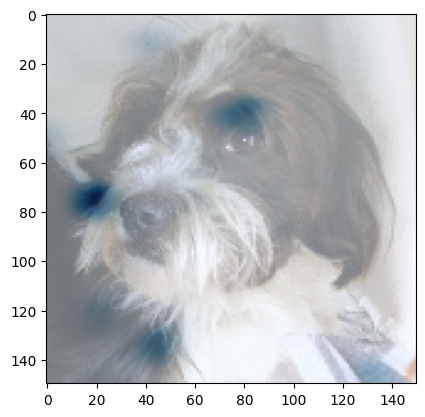

Predicted Class = Dog, Probability = 0.93172956


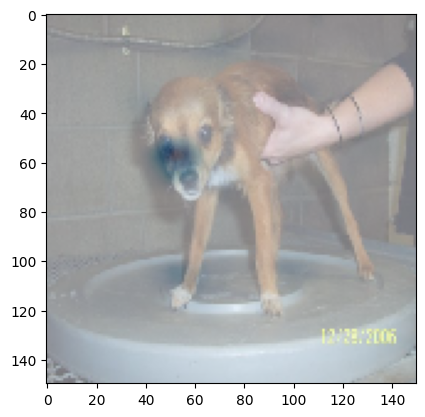

Predicted Class = Dog, Probability = 0.64675146


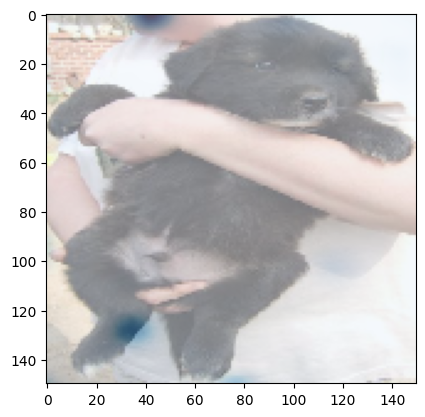

Predicted Class = Dog, Probability = 0.89813155


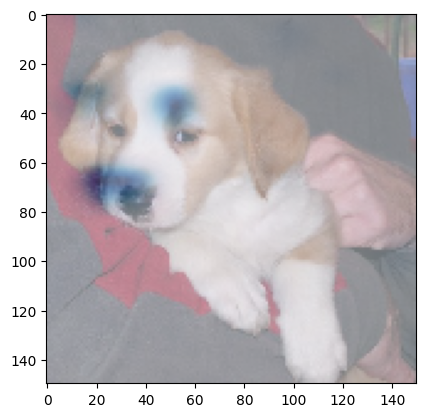

Predicted Class = Dog, Probability = 0.9493936


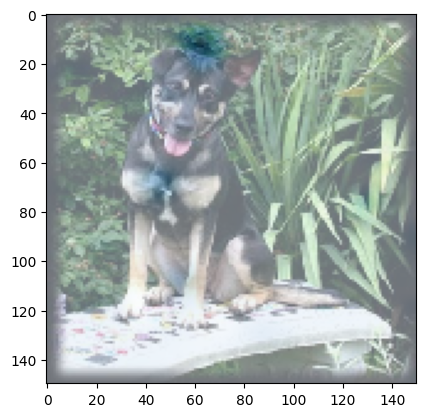

In [33]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.89145815


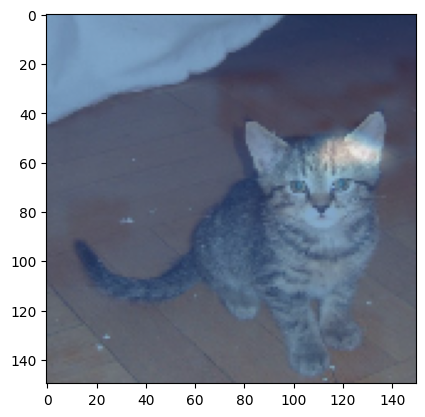

Predicted Class = Cat, Probability = 0.7637797


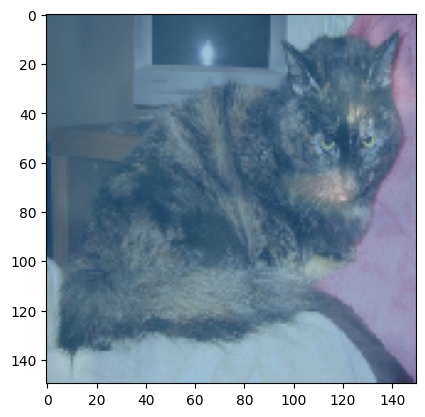

Predicted Class = Cat, Probability = 0.65706974


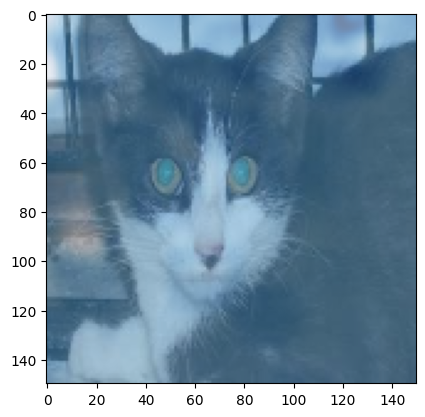

Predicted Class = Cat, Probability = 0.859855


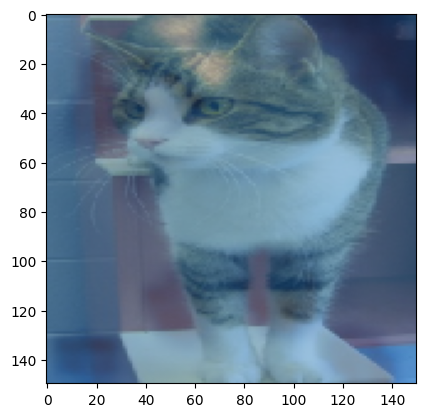

Predicted Class = Cat, Probability = 0.90857357


In [34]:
show_maps(desired_class=0, num_maps=5)

<a name="4-4"></a>

## Visualize training process

In [35]:
results = pd.DataFrame(r.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
5  0.736024  0.534403      0.739541  0.534500
6  0.745880  0.517843      0.762100  0.490692
7  0.763007  0.496523      0.721083  0.560119
8  0.780094  0.471670      0.776046  0.478882
9  0.796090  0.446593      0.815012  0.421416

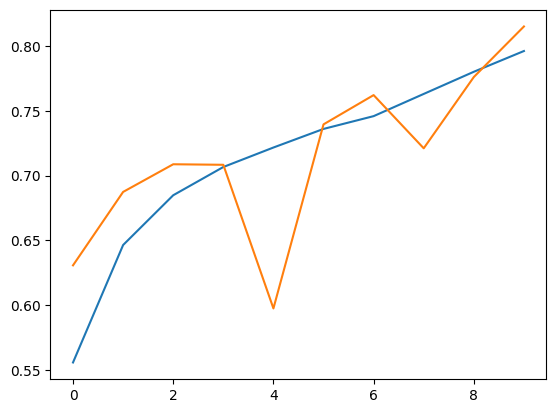

In [40]:
plt.plot(results["accuracy"])
plt.plot(results["val_accuracy"])
plt.show()

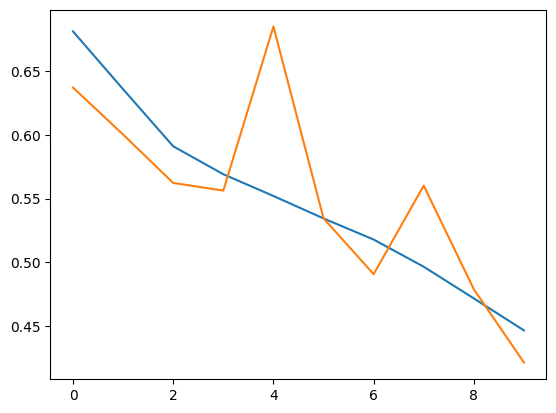

In [41]:
plt.plot(results["loss"])
plt.plot(results["val_loss"])
plt.show()

In [29]:
fig = px.line(
    results,
    y=[results["accuracy"], results["val_accuracy"]],
    template="seaborn",
    color_discrete_sequence=["#fad25a", "red"],
)
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title="Epochs"),
    yaxis=dict(color="#fad25a"),
)
fig.show()

In [30]:
fig = px.line(
    results,
    y=[results["loss"], results["val_loss"]],
    template="seaborn",
    color_discrete_sequence=["#fad25a", "red"],
)
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title="Epochs"),
    yaxis=dict(color="#fad25a"),
)
fig.show()



**Let's try using data augmentation**

<a id="5"></a>
<h1 style='background:#FFD700;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Trying Data Augmentation </center></h1>

# Trying Data Augmentation 

In [31]:
train_gen_aug = ImageDataGenerator(
    rescale=1.0 / 255,
    fill_mode="nearest",
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug = ImageDataGenerator(rescale=1.0 / 255.0)


In [32]:
train_generator = train_gen_aug.flow_from_directory(
    "/tmp/cats-v-dogs/training",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
)
validation_generator = validation_gen_aug.flow_from_directory(
    "/tmp/cats-v-dogs/validation",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
)

Found 22498 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [33]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)

model_aug = Model(inputs=inputs, outputs=x)

In [34]:
model_aug.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [35]:
r = model_aug.fit(
    train_generator,
    epochs=10,  # Training longer could yield better results
    validation_data=validation_generator,
)

Epoch 1/10
206/704 [=======>......................] - ETA: 2:14 - loss: 1.0987 - accuracy: 0.5008

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning:

Truncated File Read



704/704 [==============================] - 197s 277ms/step - loss: 0.8099 - accuracy: 0.5424 - val_loss: 0.6543 - val_accuracy: 0.6096
Epoch 2/10
704/704 [==============================] - 194s 275ms/step - loss: 0.6430 - accuracy: 0.6388 - val_loss: 0.6476 - val_accuracy: 0.6040
Epoch 3/10
704/704 [==============================] - 193s 274ms/step - loss: 0.6127 - accuracy: 0.6754 - val_loss: 0.5429 - val_accuracy: 0.7384
Epoch 4/10
704/704 [==============================] - 194s 275ms/step - loss: 0.5709 - accuracy: 0.7082 - val_loss: 0.5063 - val_accuracy: 0.7424
Epoch 5/10
704/704 [==============================] - 194s 275ms/step - loss: 0.5458 - accuracy: 0.7337 - val_loss: 0.5306 - val_accuracy: 0.7320
Epoch 6/10
704/704 [==============================] - 193s 274ms/step - loss: 0.5174 - accuracy: 0.7562 - val_loss: 0.4247 - val_accuracy: 0.8104
Epoch 7/10
704/704 [==============================] - 196s 278ms/step - loss: 0.4900 - accuracy: 0.7776 - val_loss: 0.3975 - val_accura

In [36]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.517405  0.756156  0.424683        0.8104
6  0.490025  0.777625  0.397546        0.8552
7  0.462144  0.795760  0.369685        0.8424
8  0.438362  0.810116  0.353924        0.8480
9  0.427467  0.815006  0.326135        0.8656

In [37]:
fig = px.line(
    results,
    y=[results["accuracy"], results["val_accuracy"]],
    template="seaborn",
    color_discrete_sequence=["#fad25a", "red"],
)
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title="Epochs"),
    yaxis=dict(color="#fad25a"),
)
fig.show()

In [38]:
fig = px.line(
    results,
    y=[results["loss"], results["val_loss"]],
    template="seaborn",
    color_discrete_sequence=["#fad25a", "red"],
)
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title="Epochs"),
    yaxis=dict(color="#fad25a"),
)
fig.show()

<a id="5"></a>
<h1 style='background:#FFD700;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Conclusion </center></h1>

# Conclusion 

**Using data augmentation with these hyper-parameters gave us worse results**


**We can Use [transfer learning](https://www.kaggle.com/code/fareselmenshawii/introdution-to-transfer-learning/edit/run/109466477) or a more complex architecture to solve this problem**

**We'll discuss these topics in later notebooks**

<a id="7"></a>
<h1 style='background:#FFD700;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Thank You </center></h1>


    
# Thank You

**Thank you for taking your time and going through this notebook**

**Please let me know if you have any feedback**